# Imports & Other Setup

In [1]:
# !conda activate n2v
%load_ext autoreload

import numpy as np
from matplotlib import pyplot as plt
import torch
import zarr
import os

from funlib.learn.torch.models import UNet, ConvPass
import gunpowder as gp
import logging
logging.basicConfig(level=logging.INFO)
# from tqdm.auto import trange

# from this repo
import loser
from boilerPlate import BoilerPlate
from noise2gun import *
# from segway.tasks.make_zarr_from_tiff import task_make_zarr_from_tiff_volume as tif2zarr

2021-08-24 19:45:01.880558: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
#Pick a GPU or 2
torch.cuda.set_device(3)

In [3]:
def imshow(raw, mask=None, hot=None, prediction=None, context=None):
  cols = 1 + (mask is not None) + (hot is not None) + (prediction is not None) + (context is not None)
  fig, axes = plt.subplots(1, cols, figsize=(30,30*cols))
  if len(raw.shape) == 3:
    middle = raw.shape[0] // 2
    axes[0].imshow(raw[middle], cmap='gray', vmin=0, vmax=1)
  else:
    axes[0].imshow(raw, cmap='gray', vmin=0, vmax=1)
  axes[0].set_title('Raw')
  col = 1
  if mask is not None:
    if len(mask.shape) == 3:
      axes[col].imshow(mask[middle], vmin=0, vmax=1)
    else:
      axes[col].imshow(mask, vmin=0, vmax=1)
    axes[col].set_title('Heat Mask')
    col += 1
  if hot is not None:
    if len(hot.shape) == 3:
      axes[col].imshow(hot[middle], cmap='gray', vmin=0, vmax=1)
    else:
      axes[col].imshow(hot, cmap='gray', vmin=0, vmax=1)
    axes[col].set_title("Heated image")
    col += 1
  if prediction is not None:
    if prediction.size < raw.size:
      pads = np.subtract(raw.shape, prediction.shape) // 2
      pad_tuple = []
      for p in pads:
          pad_tuple.append((p, p))
      prediction = np.pad(prediction, tuple(pad_tuple))
    if len(prediction.shape) == 3:
      axes[col].imshow(prediction[middle], cmap='gray')
    else:
      axes[col].imshow(prediction, cmap='gray')
    axes[col].set_title('Prediction')
    col += 1
  if context is not None:
    middle = context.shape[0] // 2
    if len(context.shape) == 3:
      axes[col].imshow(context[middle], cmap='gray', vmin=0, vmax=1)
    else:
      axes[col].imshow(context, cmap='gray', vmin=0, vmax=1)
    axes[col].set_title('Context')
    col += 1

In [4]:
def batch_show(batch, i=0):

    imshow(batch[raw].data[i].squeeze(), 
        batch[mask].data[i].squeeze(), 
        batch[hot].crop(batch[raw].spec.roi).data[i].squeeze(),
        batch[prediction].data[i].squeeze(),
        batch[hot].data[i].squeeze(),
        )

In [5]:
def batch_tBoard_write(batch, arrays, summary_writer, iteration=None, i=0, crops=None):
    for array in arrays:
        if array in crops.keys():
            img = batch[array].crop(batch[crops[array]].spec.roi).data[i].squeeze()
        else:
            img = batch[array].data[i].squeeze()
        mid = img.shape[0] // 2 # assumes 3D volume
        summary_writer.add_image(array.identifier, img[mid], global_step=iteration, dataformats='HW')

# Set Parameters (including data source, training variables, destination, etc.)

In [6]:
train_source = '/n/groups/htem/ESRF_id16a/tomo_ML/ReducedAnglesXray/CARE/mCTX/450p_stacks/mCTX_17keV_30nm_512c_first256.zarr' #EXPECTS ZARR VOLUME
#TODO: MAKE ABLE TO HANDLE TIFF VOLUME OR STACK

tensorboard_path = '/n/groups/htem/ESRF_id16a/tomo_ML/ReducedAnglesXray/raygun/n2g/tensorboard/'
model_name = 'noise2gun_mCTX30nm_450p'
model_path = '/n/groups/htem/ESRF_id16a/tomo_ML/ReducedAnglesXray/raygun/n2g/models/'
voxel_size=gp.Coordinate((30, 30, 30)) # set for each dataset (may be able to get from zarr)

side_length = 64#12 # in voxels for prediction (i.e. network output) - actual used ROI for network input will be bigger for valid padding
unet_depth = 4 # number of layers in unet
downsample_factor = 2
conv_padding = 'valid'
num_fmaps = 12
fmap_inc_factor=5
perc_hotPixels = 0.198
constant_upsample=True

num_epochs = 10000
batch_size = 1
init_learning_rate = 1e-5#0.0004#1e-6 # init_learn_rate = 0.0004
log_every=100

### Make sure data source is a **zarr** 

# Build Gunpowder Pipeline for Training

### Elements are:

- Data Source
- *(optional) Normalization*
- Random Patch Grab
- Pixel Heating (select and mutate *hotPixels*, i.e. training targets, and keep masks)
- Simple Augmentation (rotations/reflections)
- Stacking
- Training


In [8]:
%autoreload
from boilerPlate import BoilerPlate
import loser

In [7]:
# declare arrays to use in the pipeline
raw = gp.ArrayKey('RAW') # raw data
hot = gp.ArrayKey('HOT') # data with random pixels heated
mask = gp.ArrayKey('MASK') # data with random pixels heated
prediction = gp.ArrayKey('PREDICTION') # prediction of denoised data

source = gp.ZarrSource(    # add the data source
    train_source,  # the zarr container
    {raw: 'volumes/train'},  # which dataset to associate to the array key
    {raw: gp.ArraySpec(interpolatable=True)}  # meta-information
)

# add normalization
normalize = gp.Normalize(raw)

# add a RandomLocation node to the pipeline to randomly select a sample
random_location = gp.RandomLocation()

# add transpositions/reflections
simple_augment = gp.SimpleAugment()

# stack for batches
stack = gp.Stack(batch_size)

# add pixel heater
boilerPlate = BoilerPlate(raw, mask, hot, plate_size=side_length, perc_hotPixels=perc_hotPixels, ndims=3)

# prepare tensors for UNet
unsqueeze = gp.Unsqueeze([hot, mask, raw])

# setup a cache
cache = gp.PreCache(num_workers=os.cpu_count())

# define our network model for training
unet = UNet(
  in_channels=1,
  num_fmaps=num_fmaps,
  fmap_inc_factor=fmap_inc_factor,
  downsample_factors=[(downsample_factor,)*3,] * (unet_depth - 1),
  padding=conv_padding,
  constant_upsample=constant_upsample,
  voxel_size=voxel_size # set for each dataset
  )

model = torch.nn.Sequential(
  unet,
  ConvPass(num_fmaps, 1, [(1, 1, 1)], activation=None),
  torch.nn.Sigmoid())

# pick loss function
loss = loser.maskedMSE

# pick optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=init_learning_rate)

# create a train node using our model, loss, and optimizer
train = gp.torch.Train(
  model,
  loss,
  optimizer,
  inputs = {
    'input': hot
  },
  loss_inputs = {
    'src': prediction,
    'mask': mask,
    'target': raw
  },
  outputs = {
    0: prediction
  },
  log_dir=tensorboard_path,
  log_every=log_every,
  checkpoint_basename=model_path+model_name,
  #save_every=log_every
  )

# figure out proper ROI padding for context
conv_passes = 2 # set by default in unet
kernel_size = 3 # set by default in unet
context_side_length = 2 * np.sum([(conv_passes * (kernel_size - 1)) * (2 ** level) for level in np.arange(unet_depth - 1)]) + (conv_passes * (kernel_size - 1)) * (2 ** (unet_depth - 1)) + (conv_passes * (kernel_size - 1)) + side_length

# create request
request = gp.BatchRequest()
request.add(raw, voxel_size*side_length)
request.add(mask, voxel_size*side_length)
request.add(prediction, voxel_size*side_length)
request.add(hot, voxel_size*context_side_length)

# get performance stats
performance = gp.PrintProfilingStats(every=log_every)

# assemble pipeline
pipeline = (source +
            normalize + 
            random_location +
            simple_augment + 
            boilerPlate +
            unsqueeze + 
            cache +
            stack + 
            train +
            performance
            )

# Train

In [10]:
#Test run
with gp.build(pipeline):
  batch = pipeline.request_batch(request)

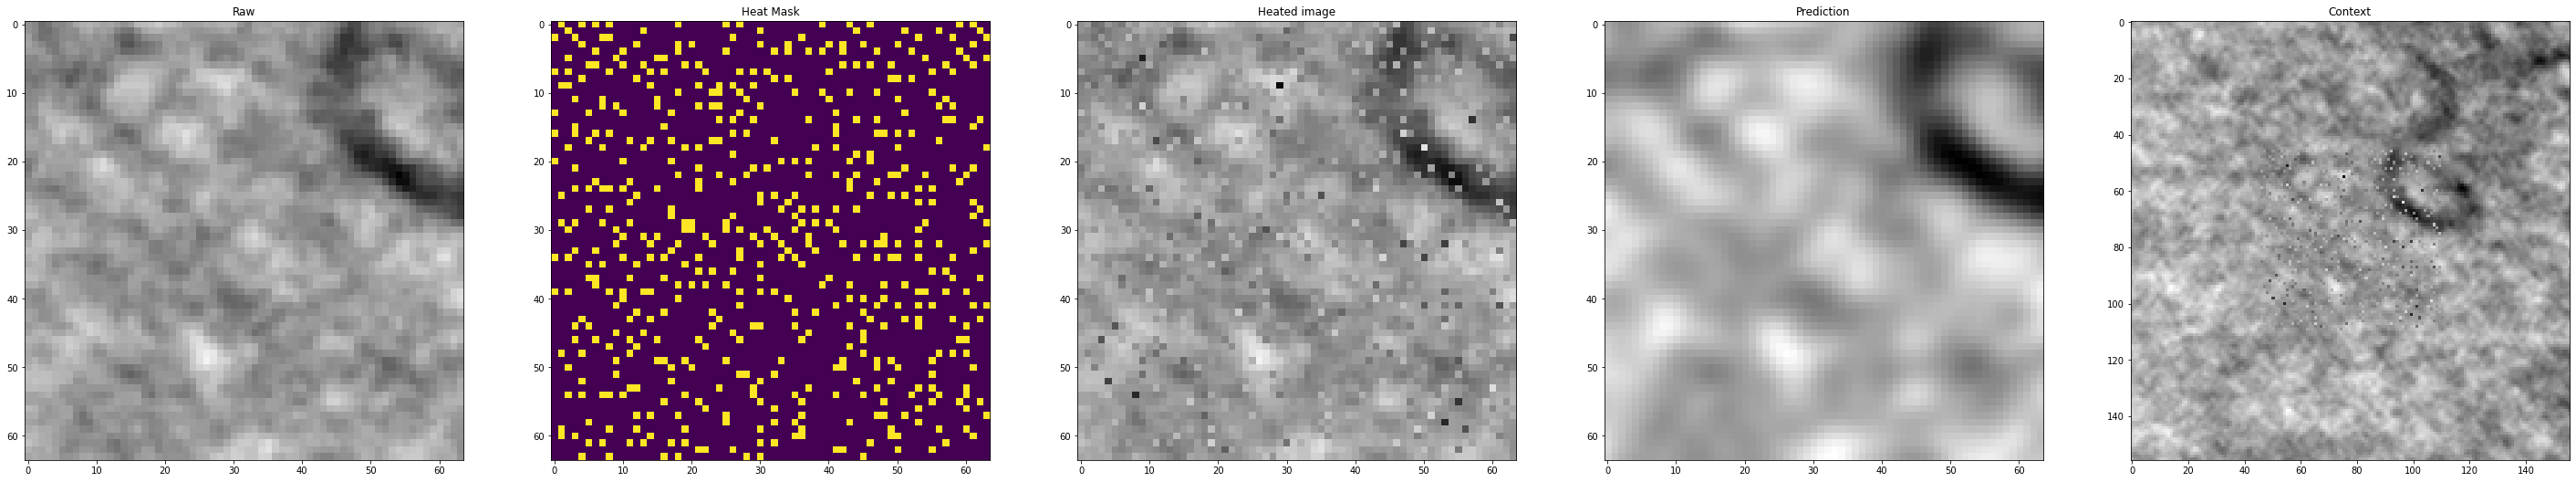

In [13]:
#Check initial results
i = 0
batch_show(batch, i)

In [8]:
#Train for real
model.train() # make sure set to training mode
with gp.build(pipeline):
  for i in range(num_epochs):
    # print(f'Training epoch {i}...')
    batch = pipeline.request_batch(request)
    if np.mod(i, log_every) == 0:
      batch_tBoard_write(batch, [raw, mask, hot, prediction], train.summary_writer, iteration=train.iteration, crops={hot:raw})
      # batch_show(batch)
      # train.summary_writer.add_figure('samples', plt.gcf(), train.iteration)

INFO:gunpowder.torch.nodes.train:Resuming training from iteration 18000
INFO:gunpowder.torch.nodes.train:Loading /n/groups/htem/ESRF_id16a/tomo_ML/ReducedAnglesXray/raygun/n2g/models/noise2gun_mCTX30nm_450p_checkpoint_18000
INFO:gunpowder.torch.nodes.train:Using device cuda
INFO:gunpowder.nodes.precache:starting new set of workers (48, cache size 50)...
INFO:gunpowder.nodes.generic_train:Train process: iteration=18001 loss=0.000000 time=3.680211
INFO:gunpowder.nodes.generic_train:Train process: iteration=18002 loss=0.000001 time=2.385852
INFO:gunpowder.nodes.generic_train:Train process: iteration=18003 loss=0.000000 time=2.362697
INFO:gunpowder.nodes.generic_train:Train process: iteration=18004 loss=0.000000 time=2.395044
INFO:gunpowder.nodes.generic_train:Train process: iteration=18005 loss=0.000000 time=2.377478
INFO:gunpowder.nodes.generic_train:Train process: iteration=18006 loss=0.000000 time=2.373317
INFO:gunpowder.nodes.generic_train:Train process: iteration=18007 loss=0.000000 

# Build Prediction Pipeline
## UNFINISHED --> SEE noise2gun.py functions instead

## Take a snapshot

In [ ]:
#set model into evaluation mode
model.eval()

stack = gp.Stack(3)

random_location = gp.RandomLocation()

predict = gp.torch.Predict(model,
                        inputs = {'input': raw},
                        outputs = {0: prediction}
                        )

request = gp.BatchRequest()
request.add(prediction, voxel_size*side_length)
request.add(raw, voxel_size*context_side_length)

predicter = (source + normalize + stack + random_location + predict)

with gp.build(predicter):
    result = predicter.request_batch(request)

i = 0
raw_data = result[raw].crop(result[prediction].spec.roi).data[i].squeeze()
imshow(raw_data, prediction=result[prediction].data[i].squeeze())

## Render full (unfinished)

In [8]:
#set model into evaluation mode
model.eval()

predict = gp.torch.Predict(model,
                        inputs = {'input': raw},
                        outputs = {0: prediction}
                        )

stack = gp.Stack(1)

scan_request = gp.BatchRequest()
scan_request.add(prediction, voxel_size*side_length)
scan_request.add(raw, voxel_size*context_side_length)

scan = gp.Scan(scan_request)

scanner = (source + normalize + stack + predict + scan)

request = gp.BatchRequest()
request.add(raw, voxel_size*side_length)
request.add(prediction, voxel_size*side_length)

In [ ]:
with gp.build(scanner):
    scan_batch = scanner.request_batch(request)

# Using Noise2Gun class from noise2gun.py

In [15]:
%autoreload
from noise2gun import *

In [16]:
data_path = '/n/groups/htem/ESRF_id16a/tomo_ML/ReducedAnglesXray/CARE/mCTX/450p_stacks/mCTX_17keV_30nm_512c_first256.zarr'

model_name = 'noise2gun_mCTX30nm_450p_20210824'

n2g = Noise2Gun(train_source=data_path,
                voxel_size=gp.Coordinate((30, 30, 30)),
                out_path=data_path,
                model_name = model_name,
                model_path = '/n/groups/htem/ESRF_id16a/tomo_ML/ReducedAnglesXray/raygun/n2g/models/',
                tensorboard_path = '/n/groups/htem/ESRF_id16a/tomo_ML/ReducedAnglesXray/raygun/n2g/tensorboard/'+model_name,
                num_epochs = 30000,
                init_learning_rate=0.0004)

INFO:gunpowder.torch.nodes.train:Starting training from scratch
INFO:gunpowder.torch.nodes.train:Using device cuda
INFO:gunpowder.nodes.precache:starting new set of workers (48, cache size 50)...
INFO:gunpowder.nodes.generic_train:Train process: iteration=1 loss=0.000001 time=2.444580
INFO:gunpowder.producer_pool:terminating workers...
INFO:gunpowder.producer_pool:joining workers...
INFO:gunpowder.producer_pool:done



	RAW: ROI: [1380:3300, 1380:3300, 1380:3300] (1920, 1920, 1920), voxel size: (30, 30, 30), interpolatable: True, non-spatial: False, dtype: <class 'numpy.float32'>, placeholder: False
	MASK: ROI: [1380:3300, 1380:3300, 1380:3300] (1920, 1920, 1920), voxel size: (30, 30, 30), interpolatable: True, non-spatial: False, dtype: <class 'bool'>, placeholder: False
	PREDICTION: ROI: [1380:3300, 1380:3300, 1380:3300] (1920, 1920, 1920), voxel size: (30, 30, 30), interpolatable: False, non-spatial: False, dtype: None, placeholder: False
	HOT: ROI: [0:4680, 0:4680, 0:4680] (4680, 4680, 4680), voxel size: (30, 30, 30), interpolatable: True, non-spatial: False, dtype: float32, placeholder: False

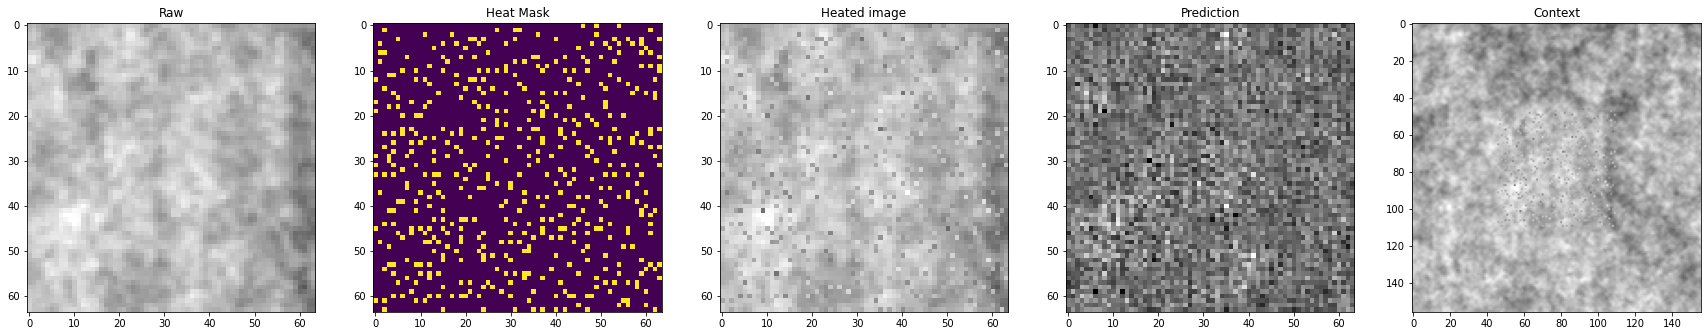

In [17]:
n2g.build_training_pipeline()
n2g.test_train()

INFO:gunpowder.torch.nodes.predict:Predicting on gpu



	PREDICTION: ROI: [1380:3300, 1380:3300, 1380:3300] (1920, 1920, 1920), voxel size: (30, 30, 30), interpolatable: False, non-spatial: False, dtype: <class 'numpy.float32'>, placeholder: False
	RAW: ROI: [0:4680, 0:4680, 0:4680] (4680, 4680, 4680), voxel size: (30, 30, 30), interpolatable: True, non-spatial: False, dtype: <class 'numpy.float32'>, placeholder: False

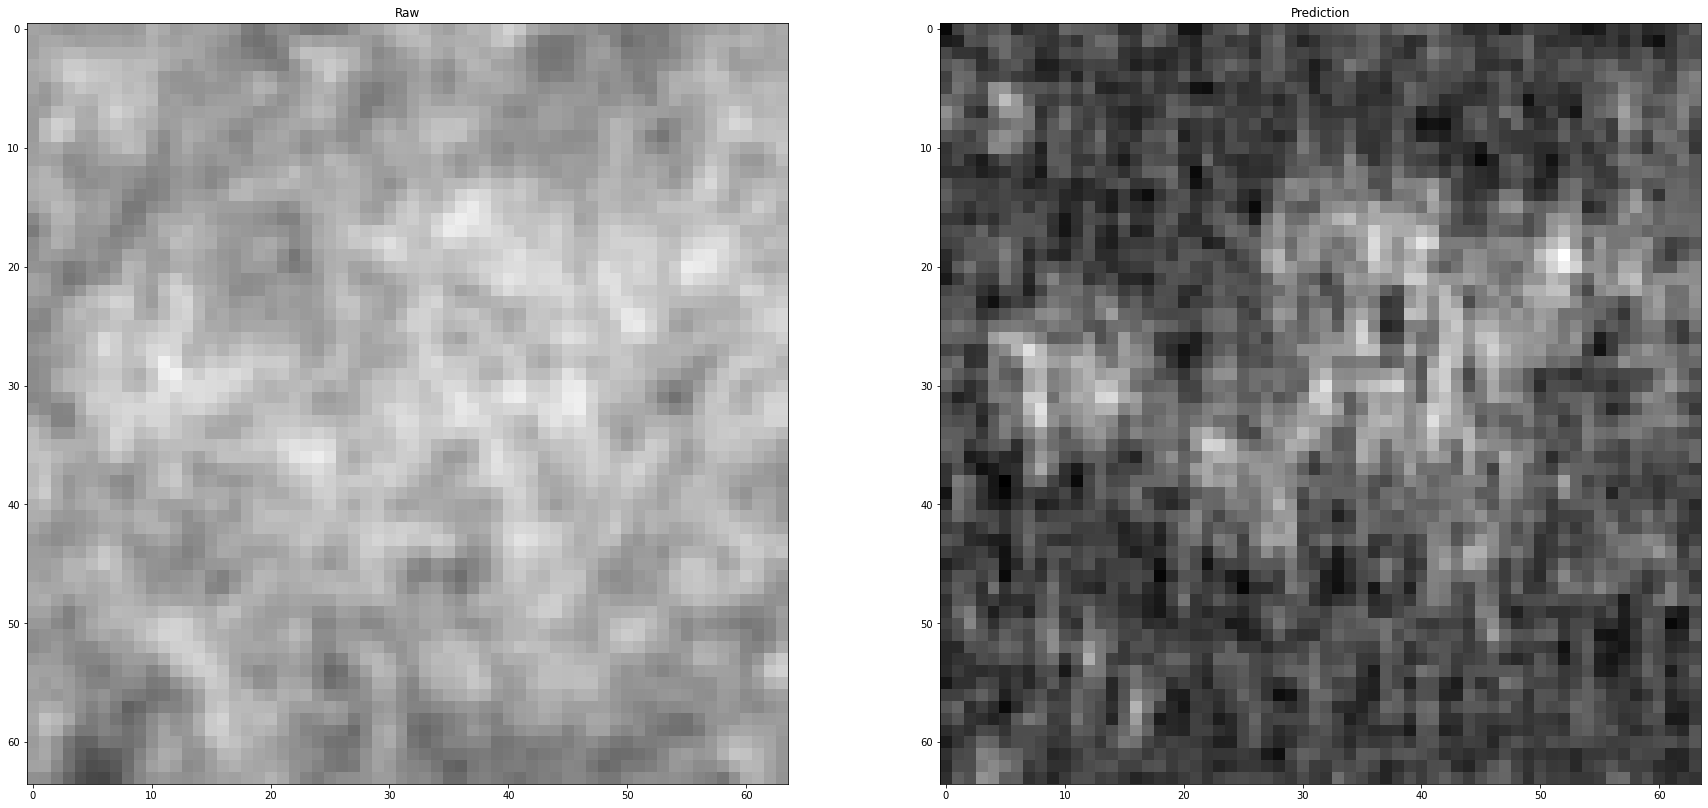

In [18]:
n2g.test_prediction()

# Scratch work and trouble shooting

In [11]:
%autoreload
from boilerPlate import BoilerPlate
import loser